In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
from flash_ansr.refine import ConvergenceError
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v6.0'
CHECKPOINT = ''

In [3]:
nsr = FlashANSR(
    expression_space=ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml')),
    flash_ansr_transformer=FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].to(device).eval(),
    beam_width=32,
    n_restarts=4,
    verbose=True,
    numeric_head=False
).to(device)

print(f'{nsr.flash_ansr_transformer.n_params:,} parameters')

27,137,058 parameters


In [4]:
nsr.max_len = 32

In [5]:
demo_expressions = [
    ('x**2', None, (-5, 5)),
    ('sin(x)', None, (-5, 5)),
    ('-x + log(x + x**4)', None, (1, 5)),
    ('x1**2 + 2*x1 + 1', (2, 1), (1, 5)),
    ('exp(- x**2)', None, (-5, 5)),
    ('x**3 + 2*x**2 + 1', (2, 1), (-5, 5)),
    ('exp(- (x - 3.4)**2)', (3.4,), (-5, 5)),
    ('exp(- (x - 1.4)**2 / 4.3)', (1.4, 4.3), (-5, 5)),
    ('cos(3.3 * x) * exp(-x * 0.5)', (3.3, 0.5,), (0, 5)),
    ('1.2', (1.2,), (-5, 5)),
    ('sin(tan(x))', None, (-5, 5)),
    ('asin((sin(x1) / x1))', None, (-10, 10)),
]

results = []

for expression, constants, xlim in tqdm(demo_expressions):
    prefix_expression = nsr.expression_space.parse_expression(expression, mask_numbers=True)
    prefix_expression_w_num = nsr.expression_space.operators_to_realizations(prefix_expression)
    prefix_expression_w_constants, constants_names = num_to_constants(prefix_expression_w_num)
    code_string = nsr.expression_space.prefix_to_infix(prefix_expression_w_constants, realization=True)
    code = codify(code_string, nsr.expression_space.variables + constants_names)

    if constants is None:
        demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0)
    else:
        demo_function = lambda x: nsr.expression_space.code_to_lambda(code)(x, 0, 0, *constants)

    x = np.random.uniform(*xlim, 100)

    y = demo_function(x)

    if isinstance(y, float):
        y = np.full_like(x, y)

    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(-1).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

    x_linspace = np.linspace(xlim[0] - 0.5, xlim[1] + 0.5, 1000)
    x_linspace_tensor = torch.tensor(x_linspace, dtype=torch.float32).unsqueeze(-1).to(device)

    try:
        nsr.fit(x_tensor, y_tensor, converge_error='raise')
    except ConvergenceError as e:
        print('Failed to converge for:', code_string)
        results.append(None)
        continue

    y_pred = [[nsr.predict(x_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]
    y_pred_linspace = [[nsr.predict(x_linspace_tensor.cpu(), nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result[1]['fits']))] for beam_id, result in enumerate(nsr._results)]

    results.append({
        '_results': nsr._results,
        'fvu': [(np.nanmean((y_pred[j][0][:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_function(x.astype(np.float32))) if len(y_pred[j]) > 0 else np.nan) for j in range(len(y_pred))],
        'log_p': [nsr._results[j][1]["log_prob"] for j in range(len(nsr._results))],
        'expression_pred_transformed': [nsr._results[j][0].transform(nsr._results[j][1]['expression'], 0, return_prefix=True) for j in range(len(nsr._results))],
        'expression_pred_transformed_infix': [nsr.expression_space.prefix_to_infix(expression_pred_transformed, power='**') for expression_pred_transformed in [nsr._results[j][0].transform(nsr._results[j][1]['expression'], 0, return_prefix=True) for j in range(len(nsr._results))]],
        'y_pred': y_pred,
        'y_pred_linspace': y_pred_linspace,
        'x': x,
        'y': y,
        'x_linspace': x_linspace,
        'x_tensor': x_tensor,
        'y_tensor': y_tensor,
        'x_linspace_tensor': x_linspace_tensor,
        'demo_function': demo_function,
        'code': code,
        'code_string': code_string,
        'prefix_expression': prefix_expression,
        'prefix_expression_w_num': prefix_expression_w_num,
        'prefix_expression_w_constants': prefix_expression_w_constants,
        'constants_names': constants_names,
        'constants': constants,
        'xlim': xlim,
    })

 50%|█████     | 6/12 [00:10<00:10,  1.77s/it]/tmp/ipykernel_3514/2357606722.py:55: RuntimeWarning: overflow encountered in square
  'fvu': [(np.nanmean((y_pred[j][0][:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_function(x.astype(np.float32))) if len(y_pred[j]) > 0 else np.nan) for j in range(len(y_pred))],
 58%|█████▊    | 7/12 [00:12<00:09,  1.82s/it]<lambdifygenerated-1736507544003155697:1: RuntimeWarning: overflow encountered in exp
<lambdifygenerated-1736507544003155697:1: RuntimeWarning: invalid value encountered in sin
 75%|███████▌  | 9/12 [00:16<00:05,  1.86s/it]<lambdifygenerated-1736507547942179437:1: RuntimeWarning: invalid value encountered in log
<lambdifygenerated-1736507547948230913:1: RuntimeWarning: invalid value encountered in arccos
/tmp/ipykernel_3514/2357606722.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  'fvu': [(np.nanmean((y_pred[j][0][:, 0].numpy() - demo_function(x.astype(np.float32)))**2) / np.nanvar(demo_

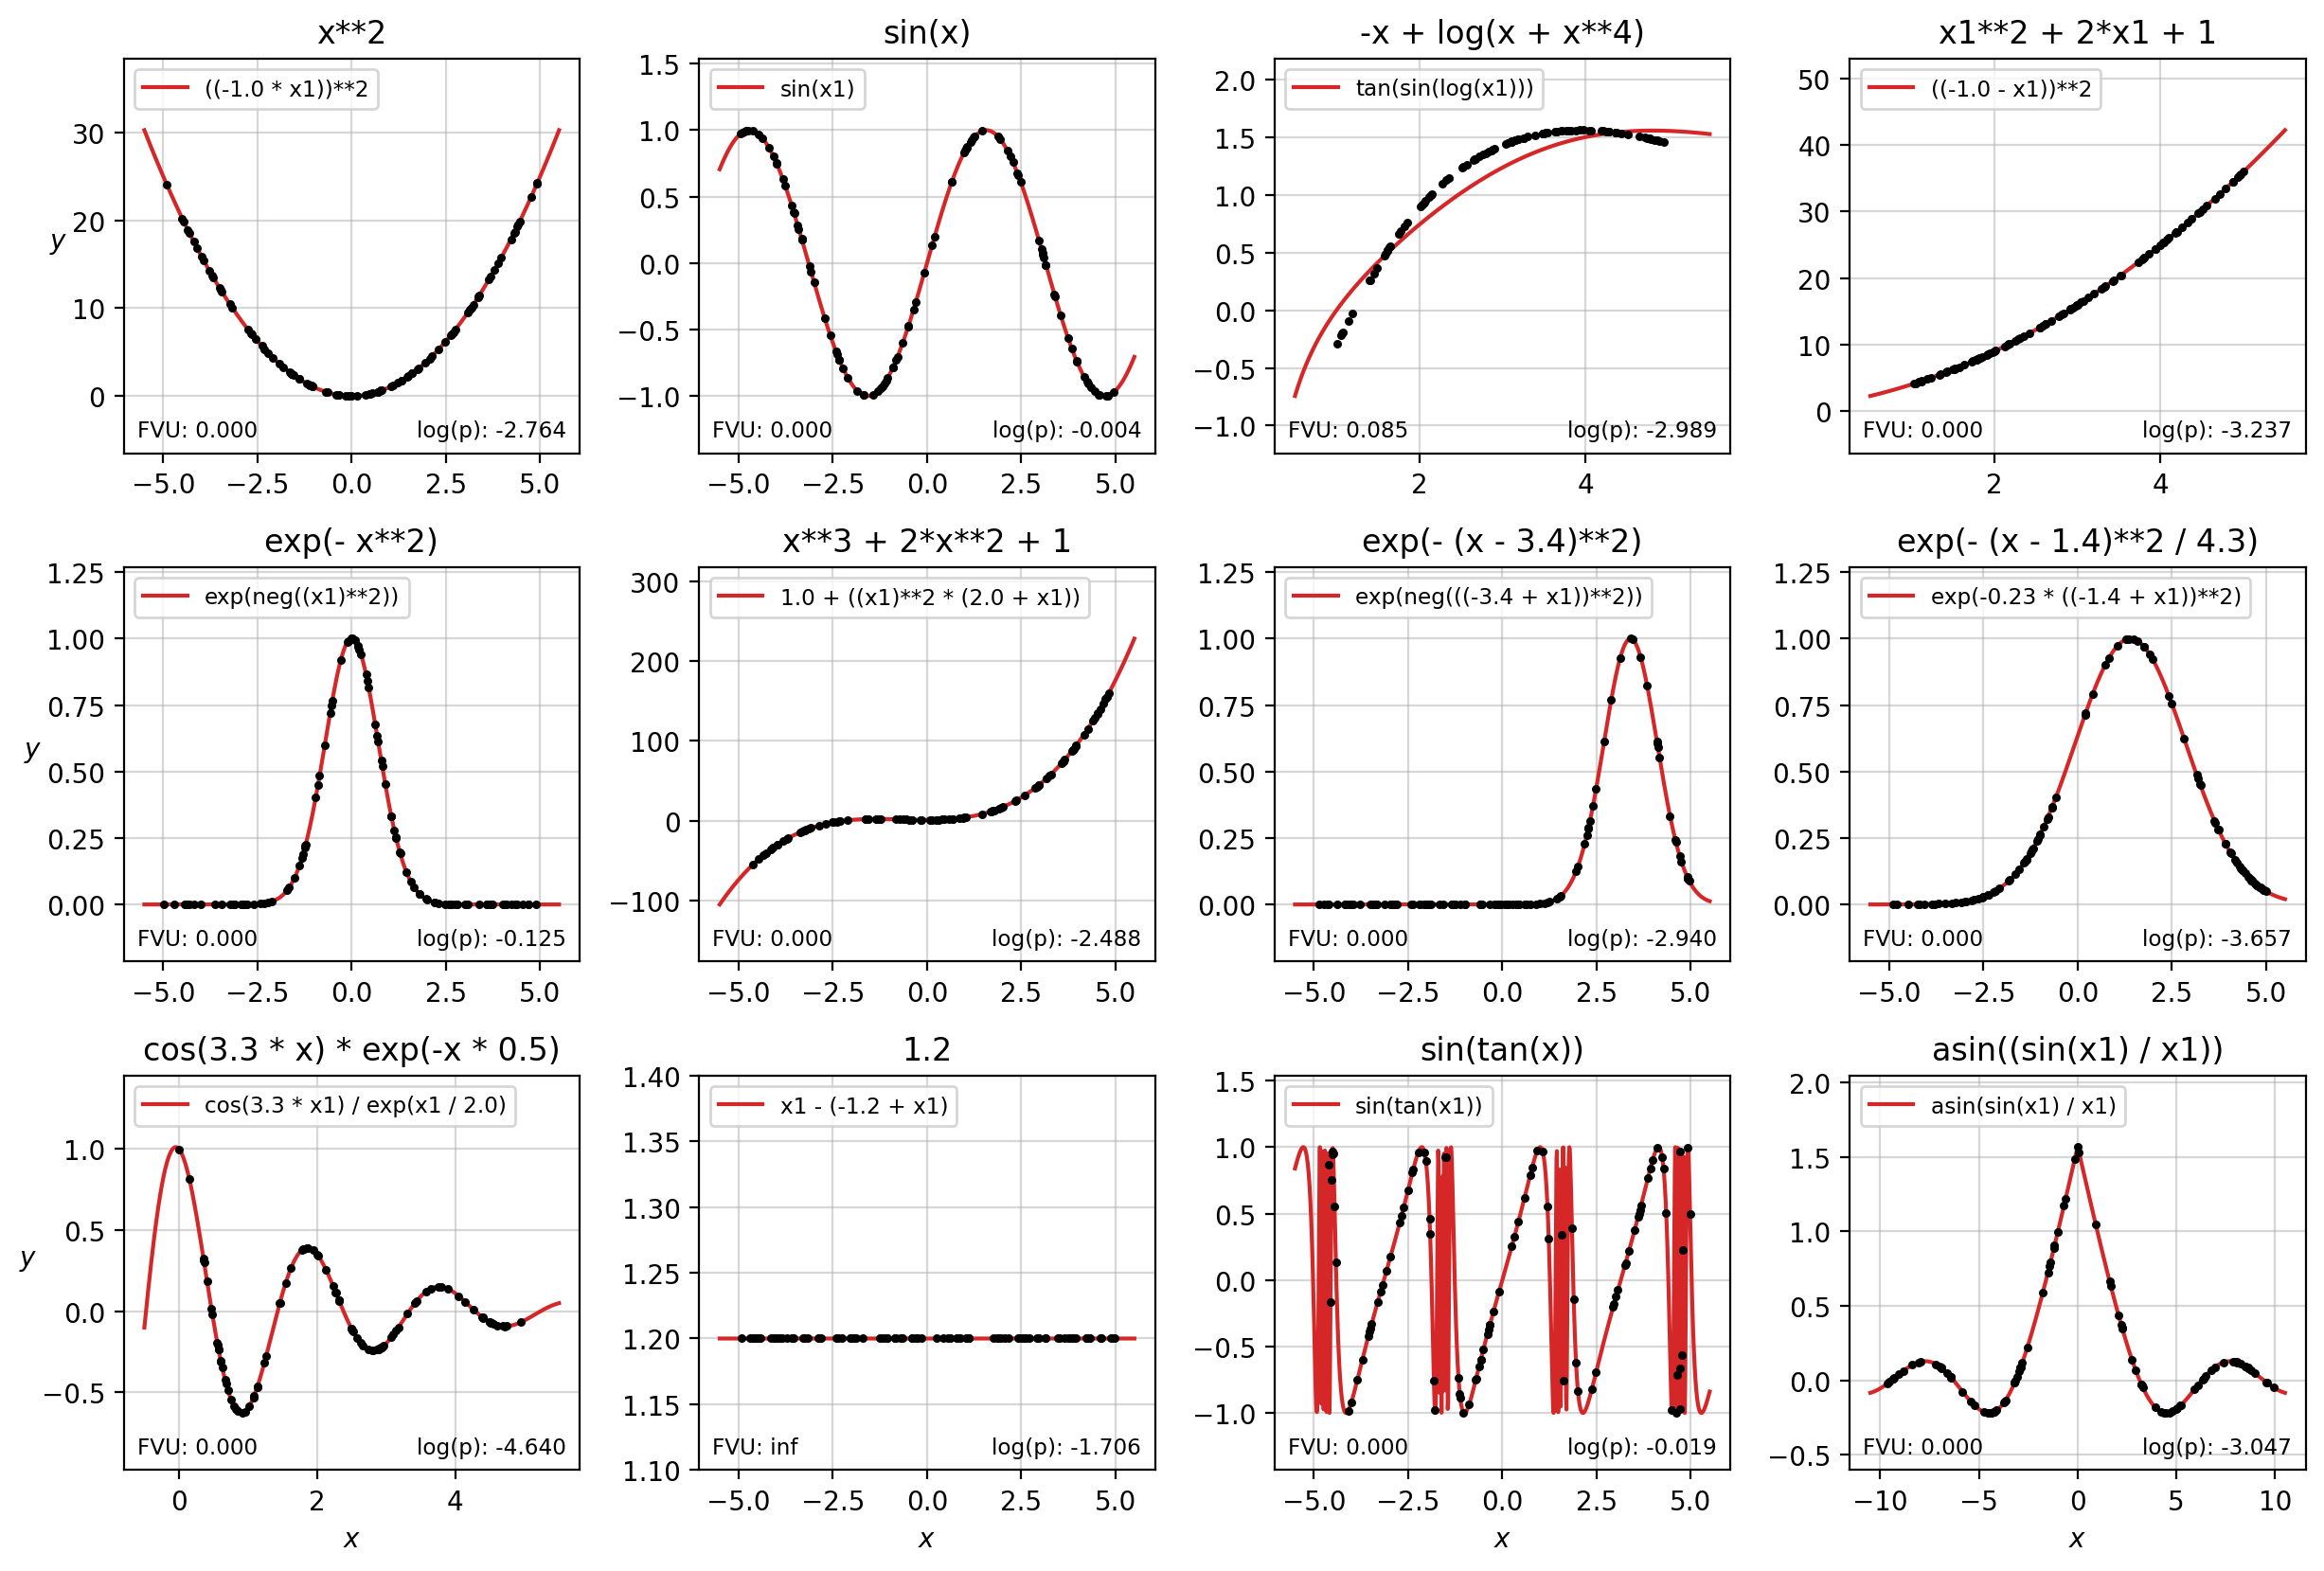

In [6]:
COLS = 4
ROWS = np.ceil(len(results) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.1, ROWS * 2.8), dpi=200)

for i, (ax, result) in enumerate(zip(axes.flat, results)):

    ax.plot(result['x_linspace'], result['y_pred_linspace'][0][0], color='tab:red', label=result['expression_pred_transformed_infix'][0])
    
    if i >= (ROWS - 1) * COLS:
        ax.set_xlabel('$x$')
    if i % COLS == 0:
        ax.set_ylabel('$y$', rotation=0, labelpad=5)

    ax.scatter(result['x'], result['y'], color='k', s=5, zorder=4)
    ax.grid(alpha=0.5)

    ax.set_title(demo_expressions[i][0])

    ylim_span = ax.get_ylim()[1] - ax.get_ylim()[0]
    new_ylim = ax.get_ylim()[0] - ylim_span * 0.15, ax.get_ylim()[1] + ylim_span * 0.2

    if ylim_span < 1e-3:
        new_ylim = ax.get_ylim()[0] - 0.1, ax.get_ylim()[1] + 0.2

    ax.set_ylim(new_ylim)

    ax.legend(loc='upper left', fontsize='small')

    ax.annotate(f'FVU: {result["fvu"][0]:.3f}', xy=(0.03, 0.03), xycoords='axes fraction', ha='left', va='bottom', fontsize='small')
    ax.annotate(f'log(p): {result["log_p"][0]:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom', fontsize='small')

for ax in axes.flat[len(results):]:
    ax.axis('off')

fig.tight_layout()